$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $

<h1>Without phase estimation - parametrized solution</h1>

Here we update the implementation of the algorithm "Detecting a marked vertex" from the paper Quantum walk speedup of backtracking algorithms by Ashley Montanaro.

We do not use Phase estimation here. Instead, we do a probabilistic sampling:
$$\frac{1}{m} \sum_{i=0}^{m-1} |\bra{00 ... 0} (R_B R_A)^i \ket{00 ... 0}|^2$$

The idea is taht we apply the operator $R_B R_A$ to the initial state $\ket{00 ... 0}$ for random number of times (between 0 and $2^k - 1$, where we pick $k$ as the number of bits of precision. If there are no marked vertices, then probability of measuring state $\ket{00 ... 0}$ will not exceed $\frac{1}{2}$, while in case of at least one marked vertex probability will be at least $60 \%$.

Keep in mind that in order to ensure the probabilities we changed transformation $D_r$, where $r$ is denoting root vertex (specifically, state $\psi_r$).

<h2>Parameters</h2>

In [1]:
num_of_layers = 3
bits_of_precision = 5

<h2>Generating layers - qubit basis state labels</h2>

In [2]:
item_size = 2*num_of_layers
root = ''
for i in range(num_of_layers):
    root += '00'
layers = [[root]]

for cur_layer in range(1,num_of_layers+1):
    layers.append([])
    for i in (layers[cur_layer-1]):
        postfix = i[item_size-(cur_layer-1)*2:]
        prefix = ''
        for j in range(item_size-(cur_layer)*2):
            prefix += '0'
        layers[cur_layer].append(prefix+'01'+postfix)
        layers[cur_layer].append(prefix+'10'+postfix)
print(layers)

[['000000'], ['000001', '000010'], ['000101', '001001', '000110', '001010'], ['010101', '100101', '011001', '101001', '010110', '100110', '011010', '101010']]


<h2>Array for $\psi$</h2>

In [3]:
psi = {}

<h2>Preparing root</h2>
<h3>$\ket{\psi_{00}}=\frac{1}{\sqrt{1+2*num\_of\_layers*4}}(\ket{00}+\sqrt{num\_of\_layers*4}\ket{01}+\sqrt{num\_of\_layers*4}\ket{10})$</h3>

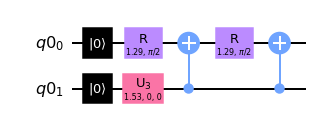

In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi, sqrt
qc = QuantumCircuit(2)

desired_vector = [
    1/sqrt(1+2*(num_of_layers*4)), # 00
    sqrt(num_of_layers*4)/sqrt(1+2*(num_of_layers*4)), # 01
    sqrt(num_of_layers*4)/sqrt(1+2*(num_of_layers*4)), # 10
    0 #11
]

q = QuantumRegister(2)
qc = QuantumCircuit(q)

qc.initialize(desired_vector, [q[0],q[1]])
qc2 = qc.decompose().decompose().decompose().decompose().decompose()

qc2.draw(output='mpl')

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi

psi[layers[0][0]] = QuantumCircuit(2*num_of_layers)
psi[layers[0][0]].u3(qc2.data[1][0].params[0],0,0,0)
psi[layers[0][0]].u3(qc2.data[3][0].params[0],0,0,1)
psi[layers[0][0]].cx(1,0)
psi[layers[0][0]].u3(qc2.data[5][0].params[0],0,0,0)
psi[layers[0][0]].cx(1,0)

psi[layers[0][0]].draw()

┌────────────────┐┌───┐┌────────────────┐┌───┐
q_0: ┤ U3(1.2898,0,0) ├┤ X ├┤ U3(1.2898,0,0) ├┤ X ├
     ├────────────────┤└─┬─┘└────────────────┘└─┬─┘
q_1: ┤ U3(1.5308,0,0) ├──■──────────────────────■──
     └────────────────┘                            
q_2: ──────────────────────────────────────────────
                                                   
q_3: ──────────────────────────────────────────────
                                                   
q_4: ──────────────────────────────────────────────
                                                   
q_5: ──────────────────────────────────────────────

<h2>States</h2>

In [7]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi

for m in range(1,num_of_layers):
    for k in layers[m]:
        psi[k] = QuantumCircuit(num_of_layers*2)
        for l in range(num_of_layers*2):
            if k[l] == '1':
                psi[k].x(len(k)-l-1)
        psi[k].u3(pi/4,0,0,2*m)
        psi[k].u3(1.23095941734,0,0,2*m+1)
        psi[k].cx(2*m+1,2*m)
        psi[k].u3(pi/4,0,0,2*m)
        psi[k].cx(2*m+1,2*m)
        
for k in layers[num_of_layers]:
    psi[k] = QuantumCircuit(num_of_layers*2)
    for l in range(len(k)):
        if k[l] == '1':
            psi[k].x(len(k)-l-1)

<h2>Operators</h2>

In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi

identity_minus_state_zero = QuantumCircuit(num_of_layers*2)

for i in range(num_of_layers*2):
    identity_minus_state_zero.x(i)

control_states = []
for i in range(num_of_layers*2-1):
    control_states.append(i)
    
identity_minus_state_zero.h(num_of_layers*2-1)
identity_minus_state_zero.mct(control_states, num_of_layers*2-1)
identity_minus_state_zero.h(num_of_layers*2-1)

for i in range(num_of_layers*2):
    identity_minus_state_zero.x(i)

d={}
for j in layers:
    for i in j: 
        d[i] = QuantumCircuit(num_of_layers*2)
        d[i] = d[i].compose(psi[i].inverse())
        d[i] = d[i].compose(identity_minus_state_zero)
        d[i] = d[i].compose(psi[i])

<h2>Implementation</h2>

Here we repeat experiment with applying $R_BR_A$ for $i$ times for each $0 \leq i \leq 2^k-1$ and gather the total probability of observing state $\ket{00 ... 0}$.

In [9]:
marked=['010101']

In [10]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi
from qiskit.circuit.library import QFT
from datetime import datetime
import time

r_a = QuantumCircuit(num_of_layers*2)

# root
r_a = r_a.compose(d[layers[0][0]])


for i in range(1,num_of_layers+1):
    if i%2 == 0:
        for j in layers[i]:
            if not j in marked:
                r_a = r_a.compose(d[j])
    
r_b = QuantumCircuit(num_of_layers*2)

for i in range(1,num_of_layers+1):
    if i%2 == 1:
        for j in layers[i]:
            if not j in marked:
                r_b = r_b.compose(d[j])

rbra = r_a
rbra = rbra.compose(r_b)

print('marked: ['+', '.join(marked)+'], outcome: ')
n = ''
n = n.zfill(num_of_layers*2)

composed_rbra = QuantumCircuit(num_of_layers*2)
summation = 0
for experiment in range(2**bits_of_precision):
    circuit = QuantumCircuit(num_of_layers*2,num_of_layers*2)
    circuit = circuit.compose(composed_rbra)
    circuit.measure(range(num_of_layers*2),range(num_of_layers*2))
    job = execute(circuit,Aer.get_backend('qasm_simulator'),shots=10000)
    counts = job.result().get_counts(circuit)
    result = counts.get(n, 0)
    print('experiment:',experiment)
    print(result/100,'%')
    #print(counts)
    summation += result
    composed_rbra = composed_rbra.compose(rbra)
print('final probability:',summation/(10000*(2**bits_of_precision)))

marked: [010101], outcome: 
experiment: 0
100.0 %
experiment: 1
84.52 %
experiment: 2
80.39 %
experiment: 3
82.11 %
experiment: 4
61.01 %
experiment: 5
58.56 %
experiment: 6
53.38 %
experiment: 7
43.04 %
experiment: 8
45.5 %
experiment: 9
43.0 %
experiment: 10
39.64 %
experiment: 11
55.05 %
experiment: 12
55.04 %
experiment: 13
60.31 %
experiment: 14
80.23 %
experiment: 15
79.82 %
experiment: 16
85.89 %
experiment: 17
95.9 %
experiment: 18
82.52 %
experiment: 19
85.84 %
experiment: 20
80.25 %
experiment: 21
61.7 %
experiment: 22
64.1 %
experiment: 23
53.9 %
experiment: 24
40.7 %
experiment: 25
46.77 %
experiment: 26
41.86 %
experiment: 27
40.0 %
experiment: 28
52.5 %
experiment: 29
51.77 %
experiment: 30
63.64 %
experiment: 31
77.97 %
final probability: 0.639659375
